In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Model and Tokenize

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.9 MB/s eta 0:00:00


In [ ]:
from transformers import set_seed, GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification

set_seed(731) 

model_config = GPT2Config.from_pretrained('gpt2', num_labels=2) 
model = GPT2ForSequenceClassification.from_pretrained('gpt2', config=model_config)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left" 
tokenizer.pad_token = tokenizer.eos_token

model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Build dataset

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/Group assignment/text mining/GPT2/gptdatawithoutnlp.csv')
test=pd.read_csv('/content/drive/MyDrive/Group assignment/text mining/predictdata.csv')
display(train)
#display(test)

,review,label,split
0,ONT2 Amazon,0,train
1,Good company to work,1,train
2,Outbound Problem Solver,0,train
3,Very Friendly environment,1,train
4,Local Data Quality Evaluator - Geo EMEA,1,train
...,...,...,...
15923,Site Reliability Engineer,1,test
15924,Great place to learn but not a culture of reco...,0,test
15925,"Great people, horrible technology",0,test
15926,Love the place,1,test


In [ ]:
import os
import pandas as pd
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, train=True):
        super().__init__()
        self.train = train
        self.data = pd.read_csv(os.path.join('/content/drive/MyDrive/Group assignment/text mining/GPT2', 'gptdata.csv' if train else '/content/drive/MyDrive/Group assignment/text mining/predictdata.csv'))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        record = self.data.iloc[index]
        text = record['review']
        if self.train:
            return {'text': text, 'label': record['label']}
        else:
            return {'text': text, 'label': '0'}

train_dataset = MyDataset(train=True)
test_dataset = MyDataset(train=False)


In [ ]:
for i in range(10):
    print(train_dataset.__getitem__(i)['text'])

ONT2 Amazon
Good company to work
Outbound Problem Solver
Very Friendly environment
Local Data Quality Evaluator - Geo EMEA
Join TRMS only if you love Drugs!
Account Manager at AWS
Review
Good people twisted by performance review process old or new.
Physically demanding


Data Collator

In [ ]:
class Gpt2ClassificationCollator(object):
    def __init__(self, tokenizer, max_seq_len=None):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        
        return
    
    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [int(sequence['label']) for sequence in sequences]
        inputs = self.tokenizer(text=texts,
                                return_tensors='pt',
                                padding=True,
                                truncation=True,
                                max_length=self.max_seq_len)
        inputs.update({'labels': torch.tensor(labels)})
        
        return inputs

gpt2classificationcollator = Gpt2ClassificationCollator(tokenizer=tokenizer,max_seq_len=60)

Data Loader

In [ ]:
from torch.utils.data import DataLoader, random_split

train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True,
                              collate_fn=gpt2classificationcollator)
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=32,
                            shuffle=False,
                            collate_fn=gpt2classificationcollator)
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False,
                             collate_fn=gpt2classificationcollator)

Optimizer & LR

In [ ]:
from transformers import AdamW, get_cosine_schedule_with_warmup

total_epochs = 10

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters,
                  lr=1e-5,
                  eps=1e-8)

num_train_steps = len(train_dataloader) * total_epochs
num_warmup_steps = int(num_train_steps * 0.1) 

lr_scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps=num_warmup_steps,num_training_steps = num_train_steps)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Train & Validation

In [ ]:
import torch

def train(dataloader, optimizer, scheduler, device_):
    global model
    model.train()
    
    prediction_labels = []
    true_labels = []
    
    total_loss = []
    
    for batch in dataloader:
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device_) for k, v in batch.items()}
        
        
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # prevent exploding gradient

        optimizer.step()
        scheduler.step()
        
        prediction_labels += logits.argmax(axis=-1).flatten().tolist()
    
    return true_labels, prediction_labels, total_loss

def validation(dataloader, device_):
    global model
    model.eval()
    
    prediction_labels = []
    true_labels = []
    
    total_loss = []
    
    for batch in dataloader:
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device_) for k, v in batch.items()}
        
        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss.append(loss.item())

            prediction_labels += logits.argmax(axis=-1).flatten().tolist()
        
    return true_labels, prediction_labels, total_loss

Run

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

all_loss = {'train_loss': [], 'val_loss': []}
all_acc = {'train_acc': [], 'val_acc': []}

for epoch in range(total_epochs):
    y, y_pred, train_loss = train(train_dataloader, optimizer, lr_scheduler, device) 
    train_acc = accuracy_score(y, y_pred)
    
    y, y_pred, val_loss = validation(val_dataloader, device)
    val_acc = accuracy_score(y, y_pred)
    
    all_loss['train_loss'] += train_loss
    all_loss['val_loss'] += val_loss
    
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)
    
    print(f'Epoch: {epoch}, train_loss: {torch.tensor(train_loss).mean():.3f}, train_acc: {train_acc:.3f}, val_loss: {torch.tensor(val_loss).mean():.3f}, val_acc: {val_acc:.3f}') 

Epoch: 0, train_loss: 0.962, train_acc: 0.563, val_loss: 0.643, val_acc: 0.659
Epoch: 1, train_loss: 0.627, train_acc: 0.651, val_loss: 0.598, val_acc: 0.685
Epoch: 2, train_loss: 0.600, train_acc: 0.673, val_loss: 0.574, val_acc: 0.706
Epoch: 3, train_loss: 0.576, train_acc: 0.692, val_loss: 0.577, val_acc: 0.696
Epoch: 4, train_loss: 0.569, train_acc: 0.695, val_loss: 0.566, val_acc: 0.697
Epoch: 5, train_loss: 0.570, train_acc: 0.691, val_loss: 0.568, val_acc: 0.707
Epoch: 6, train_loss: 0.565, train_acc: 0.703, val_loss: 0.569, val_acc: 0.698
Epoch: 7, train_loss: 0.562, train_acc: 0.705, val_loss: 0.562, val_acc: 0.705
Epoch: 8, train_loss: 0.552, train_acc: 0.710, val_loss: 0.562, val_acc: 0.707
Epoch: 9, train_loss: 0.551, train_acc: 0.713, val_loss: 0.562, val_acc: 0.707


In [ ]:
### Check Loss

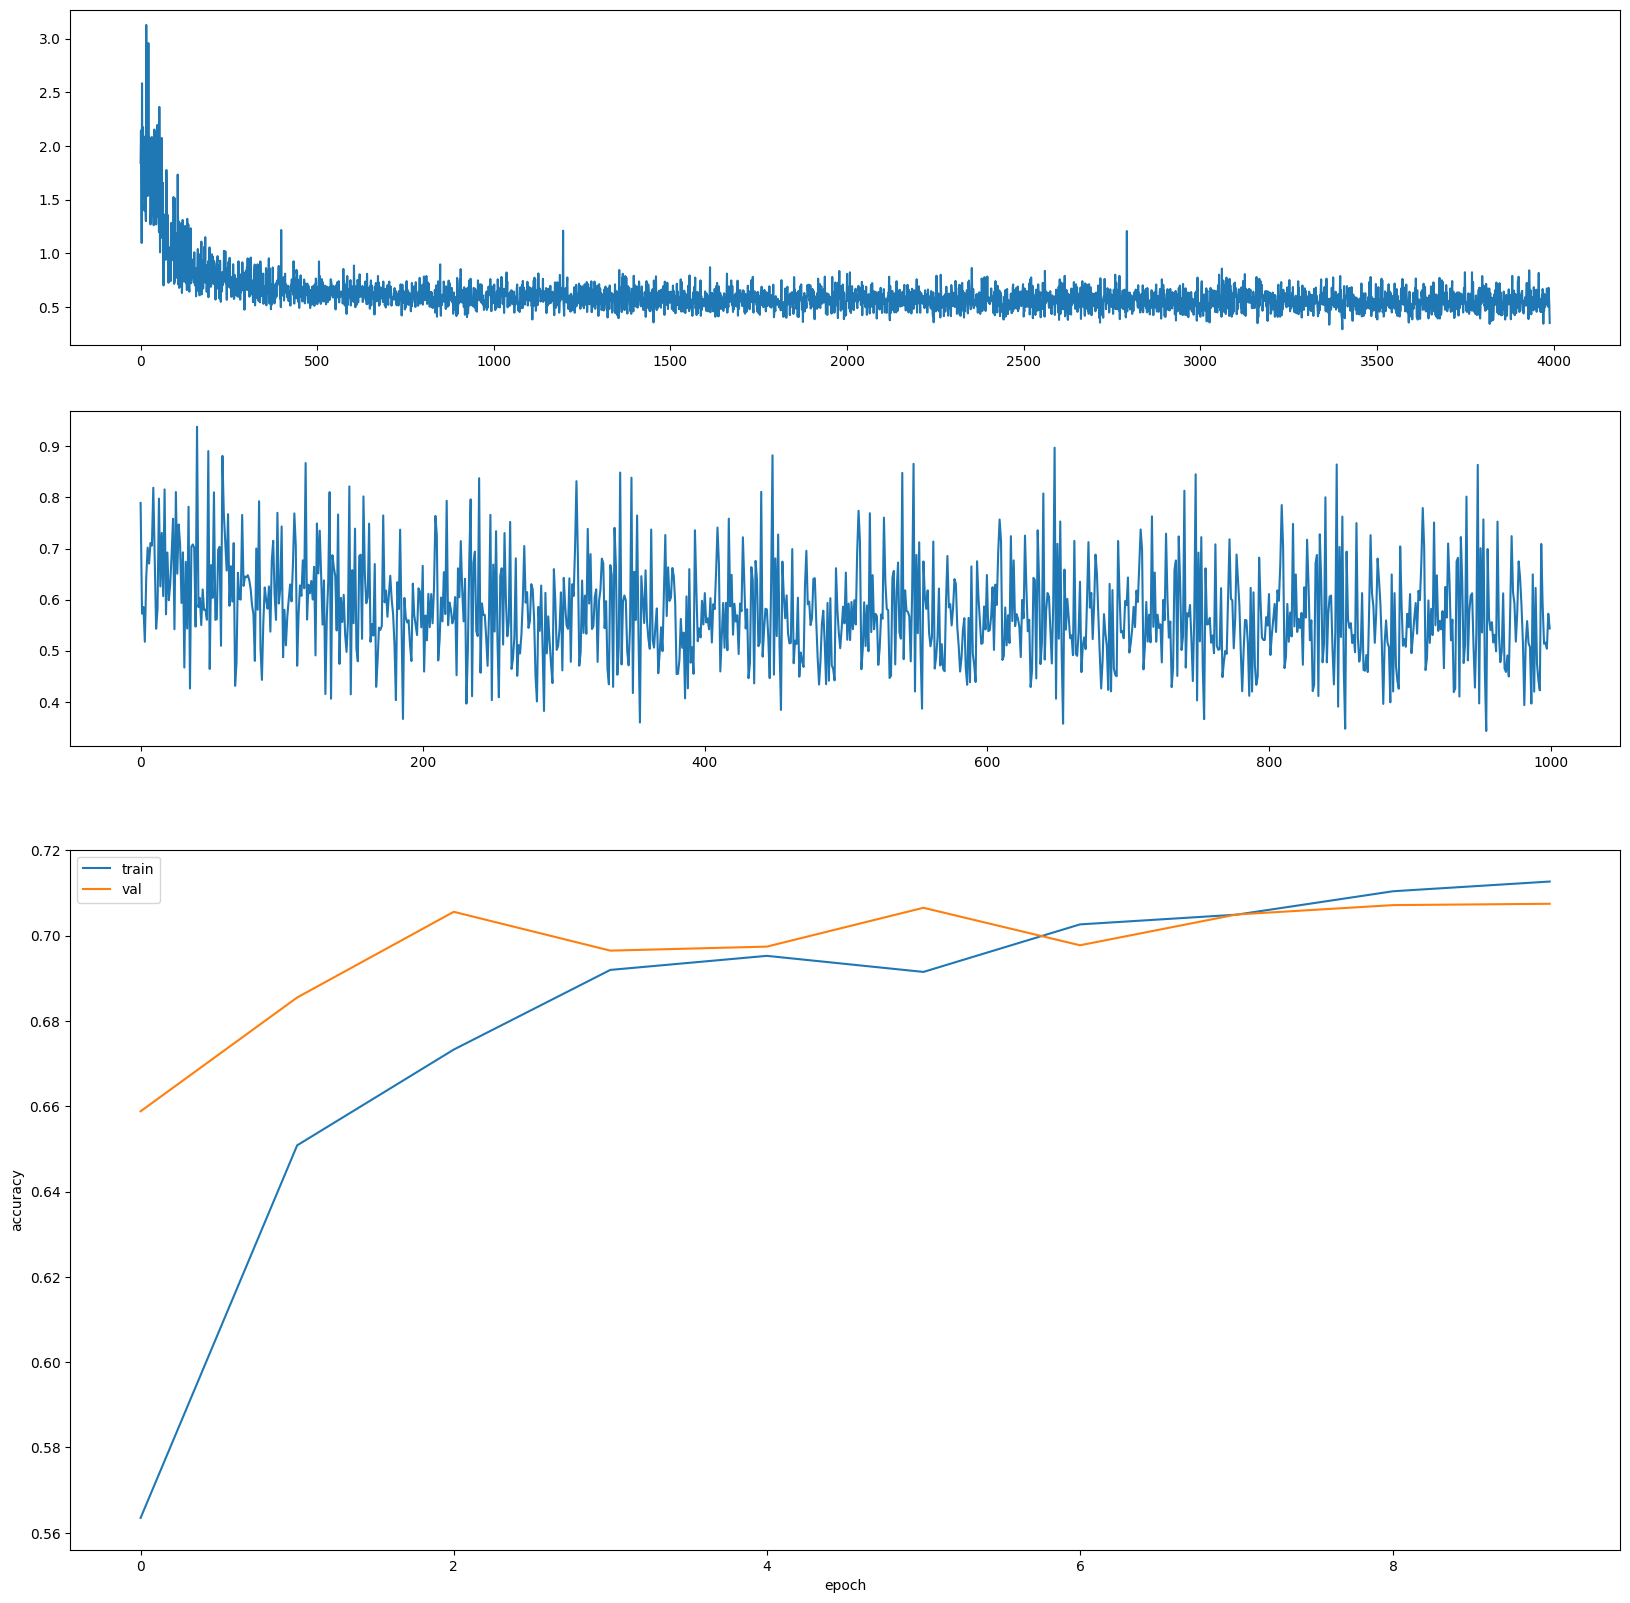

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(20,20))
a = fig.add_subplot(4, 1, 1)
b = fig.add_subplot(4, 1, 2)
c = fig.add_subplot(2, 1, 2)
a.plot(all_loss['train_loss'])
b.plot(all_loss['val_loss'])
c.plot(all_acc['train_acc'])
c.plot(all_acc['val_acc'])
c.set(xlabel='epoch', ylabel='accuracy')
c.legend(['train', 'val'])

pass